In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import libraries

In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.5 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from statsmodels.tsa.stattools import adfuller  # kiểm tra chuỗi có tính dừng không -> có phụ thuộc vào thời gian chạy không?
from statsmodels.tsa.seasonal import seasonal_decompose   # phân tích -> thành phần chuỗi gốc, thành phần xu hướng, thành phần mùa vụ và thành phần nhiễu

from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [4]:
%cd /content/drive/MyDrive/IS403/Project/Data/

/content/drive/.shortcut-targets-by-id/1H00NdDTisvXwJcMmLshBS2Qn7PUvkU8H/IS403/Project/Data


# Eval Function

In [6]:
def eval(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [7]:
def test_stationarity(timeseries):

    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='yellow', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC') # tự động lựa chọn số lượng lag tối ưu dựa trên tiêu chí AIC ->
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

In [8]:
def train_test_valid(data):
  test_size  = 0.3
  valid_size = 0.1

  test_split_idx  = int(data.shape[0] * (1-test_size))
  valid_split_idx = int(data.shape[0] * (1-(valid_size+test_size)))

  return data[:valid_split_idx], data[valid_split_idx:test_split_idx+1], data[test_split_idx+1:]

# AMAZON

## Data

In [9]:
df_amz = pd.read_csv("AMZN.csv")
df_amz

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,58.602501,58.982498,57.599998,58.117500,58.117500,82142000
1,2017-12-04,58.692501,58.759998,56.400002,56.697498,56.697498,118638000
2,2017-12-05,56.412998,57.963501,56.237000,57.078499,57.078499,81596000
3,2017-12-06,56.899502,57.794498,56.804001,57.617500,57.617500,57066000
4,2017-12-07,57.829498,58.159500,57.549999,57.989498,57.989498,50232000
...,...,...,...,...,...,...,...
1384,2023-06-05,123.360001,125.800003,123.029999,125.300003,125.300003,47950100
1385,2023-06-06,125.070000,127.400002,125.000000,126.610001,126.610001,45695200
1386,2023-06-07,127.010002,127.370003,120.629997,121.230003,121.230003,95663300
1387,2023-06-08,123.010002,125.629997,122.260002,124.250000,124.250000,62159300


## Preprocessing

### Check null and na value

In [10]:
df_amz.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
df_amz.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check datatype of each column

In [12]:
print("Date column data type: ", type(df_amz['Date'][0]))
print("Open column data type: ", type(df_amz['Open'][0]))
print("Close column data type: ", type(df_amz['Close'][0]))
print("High column data type: ", type(df_amz['High'][0]))
print("Low column data type: ", type(df_amz['Low'][0]))
print("Adj Close column data type: ", type(df_amz['Adj Close'][0]))
print("Volume column data type: ", type(df_amz['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [13]:
df_amz['Date'] = pd.to_datetime(df_amz.Date)

### Choose X

In [14]:
close_amz=df_amz[['Close']]

## EDA

### Get the duration of dataset

In [15]:
print("Starting date: ",df_amz.iloc[0][0])
print("Ending date: ", df_amz.iloc[-1][0])
print("Duration: ", df_amz.iloc[-1][0]-df_amz.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-06-09 00:00:00
Duration:  2016 days 00:00:00


### Visualize the per day closing price of the stock

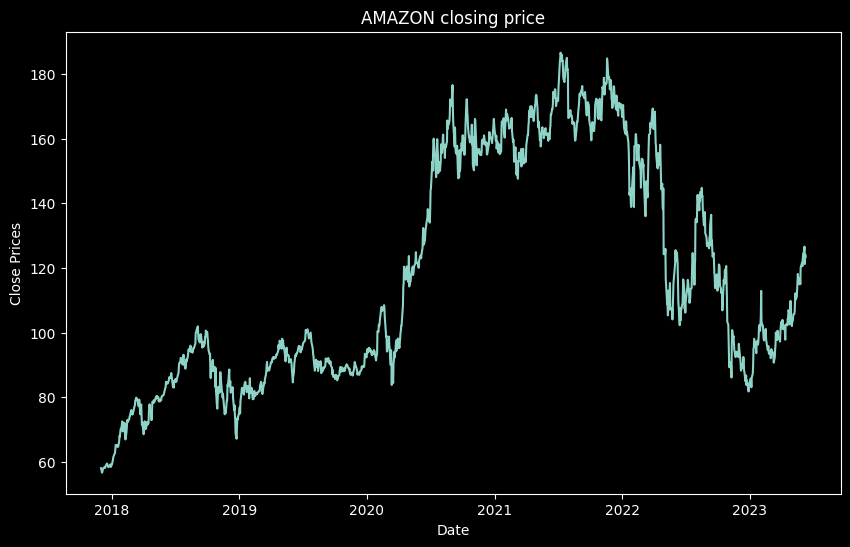

In [16]:
x_axis = np.array(df_amz['Date'])

plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(x_axis,close_amz)
plt.title('AMAZON closing price')
plt.show()

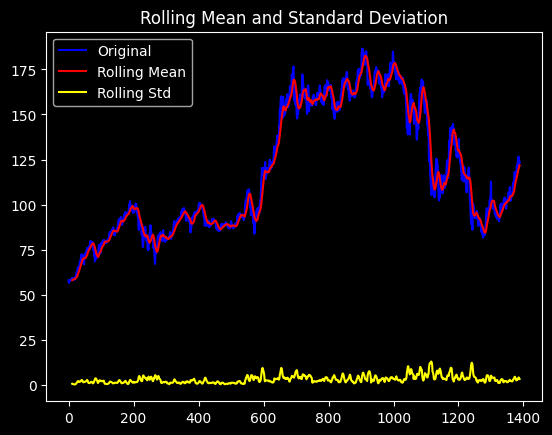

Results of dickey fuller test
Test Statistics                  -1.929368
p-value                           0.318374
No. of lags used                  0.000000
Number of observations used    1388.000000
critical value (1%)              -3.435070
critical value (5%)              -2.863625
critical value (10%)             -2.567880
dtype: float64


In [17]:
test_stationarity(close_amz)

## Train, test, valid

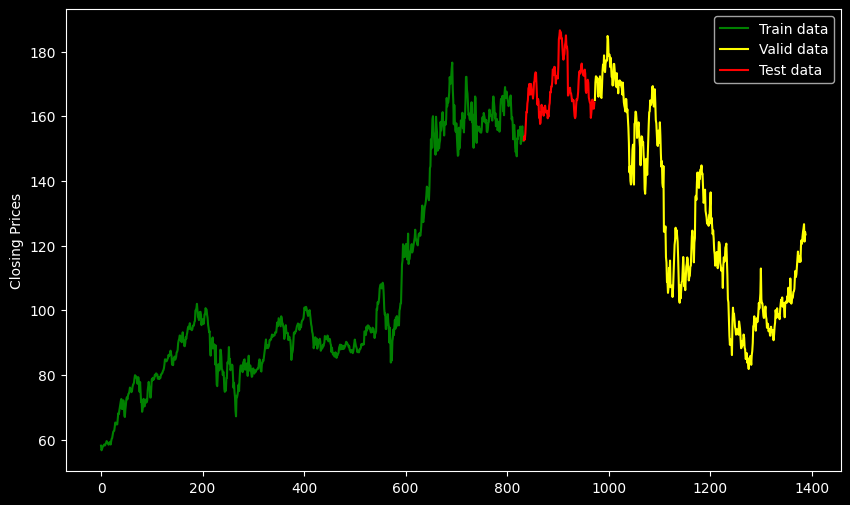

In [18]:
close_amz = close_amz.reset_index(drop=True)

train_data, test_data, valid_data = train_test_valid(close_amz)

plt.figure(figsize=(10,6))
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(valid_data, 'yellow', label='Valid data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [19]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

## Build model

### Choose p, q, d

In [20]:
model_autoARIMA = auto_arima(y_train, start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

model_autoARIMA.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=10188.771, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3723.944, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.80 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3725.925, Time=0.80 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.56 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.40 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3723.511, Time=0.69 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7055.752, Time=0.50 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3723.960, Time=1.32 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3725.500, Time=1.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8123.950, Time=0.07 sec
 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  833
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1857.756
Date:                Wed, 21 Jun 2023   AIC                           3723.511
Time:                        03:15:53   BIC                           3742.411
Sample:                             0   HQIC                          3730.758
                                - 833                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1469      0.193      0.759      0.448      -0.232       0.526
ar.L1          0.9986      0.002    558.593      0.000       0.995       1.002
ma.L1         -0.0666      0.025     -2.657      0.008      -0.116      -0.017
sigma2         5.0310      0.154     32.612      0.000       4.729       5.333
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               355.17
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               3.24   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build model

In [21]:
model = ARIMA(y_train, order=(1,0,1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  833
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1857.756
Date:                Wed, 21 Jun 2023   AIC                           3723.511
Time:                        03:15:53   BIC                           3742.411
Sample:                             0   HQIC                          3730.758
                                - 833                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.8049     28.323      3.700      0.000      49.293     160.317
ar.L1          0.9986      0.002    558.510      0.000       0.995       1.002
ma.L1         -0.0666      0.025     -2.657      0.008      -0.116      -0.017
sigma2         5.0310      0.154     32.611      0.000       4.729       5.333
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               355.21
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               3.24   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [22]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1))


x_val= np.array(valid_data.index).reshape(-1, 1)
y_val = np.array(valid_data['Close'])
y_pred_val =  model.predict(start=int(x_val[0]), end=int(len(x_val)+x_val[0]-1))

In [23]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  20.45092353724556
MAPE:  11.955338554749282
RMSE:  22.077980330466517

** Validate **
MAE:  22.787080357508618
MAPE:  19.973936446975998
RMSE:  25.60138456492779


## Forecast

In [24]:
last_index =  close_amz.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1))

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[126.67240534 126.64184823 126.61133383 126.58086207 126.55043289
 126.52004623 126.48970203 126.45940024 126.42914079 126.39892362
 126.36874867 126.3386159  126.30852522 126.2784766  126.24846997
 126.21850526 126.18858243 126.15870141 126.12886215 126.09906459
 126.06930866 126.03959431 126.00992148 125.98029012 125.95070017
 125.92115156 125.89164424 125.86217816 125.83275325 125.80336946]


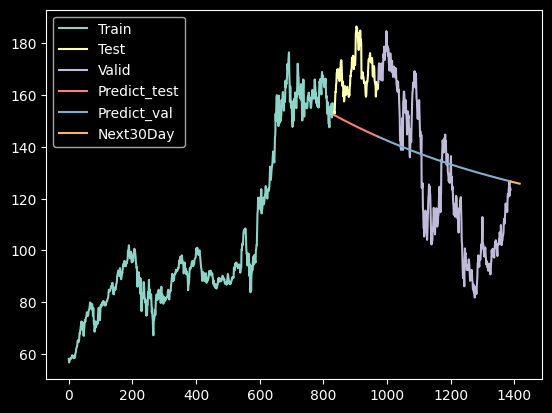

In [25]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(valid_data.index, valid_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(valid_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()

# NVIDIA

## Data

In [26]:
df_nvda = pd.read_csv("NVDA.csv")
df_nvda

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,49.827499,50.032501,48.117500,49.419998,48.908009,81154800
1,2017-12-04,50.012501,50.075001,46.125000,46.665001,46.181549,124084400
2,2017-12-05,45.599998,48.174999,45.145000,46.935001,46.448750,98148800
3,2017-12-06,46.424999,47.535000,46.209999,47.314999,46.824821,46703200
4,2017-12-07,47.990002,48.400002,47.529999,47.997501,47.500244,54260000
...,...,...,...,...,...,...,...
1384,2023-06-05,389.089996,395.649994,387.070007,391.709991,391.669464,39609400
1385,2023-06-06,388.299988,391.600006,381.480011,386.540009,386.500000,38872900
1386,2023-06-07,389.149994,394.989990,373.559998,374.750000,374.750000,51199800
1387,2023-06-08,377.239990,388.640015,375.049988,385.100006,385.100006,41777200


## Preprocessing

### Check null and na value

In [27]:
df_nvda.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [28]:
df_nvda.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check datatype of each column

In [29]:
print("Date column data type: ", type(df_nvda['Date'][0]))
print("Open column data type: ", type(df_nvda['Open'][0]))
print("Close column data type: ", type(df_nvda['Close'][0]))
print("High column data type: ", type(df_nvda['High'][0]))
print("Low column data type: ", type(df_nvda['Low'][0]))
print("Adj Close column data type: ", type(df_nvda['Adj Close'][0]))
print("Volume column data type: ", type(df_nvda['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [30]:
df_nvda['Date'] = pd.to_datetime(df_nvda.Date)

### Choose X

In [31]:
close_nvda = df_nvda[['Close']]

## EDA

### Get the duration of dataset

In [32]:
print("Starting date: ",df_nvda.iloc[0][0])
print("Ending date: ", df_nvda.iloc[-1][0])
print("Duration: ", df_nvda.iloc[-1][0]-df_nvda.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-06-09 00:00:00
Duration:  2016 days 00:00:00


### Visualize the per day closing price of the stock

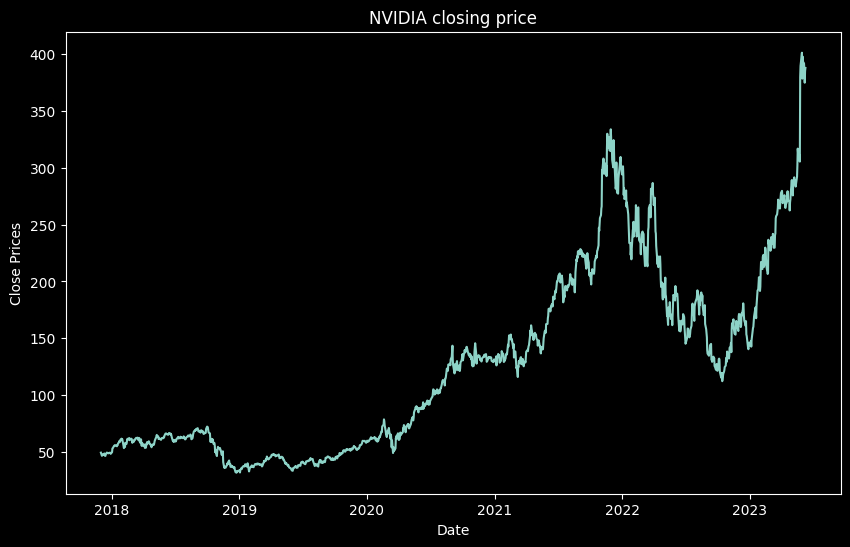

In [33]:
x_axis = np.array(df_nvda['Date'])

plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(x_axis,close_nvda)
plt.title('NVIDIA closing price')
plt.show()

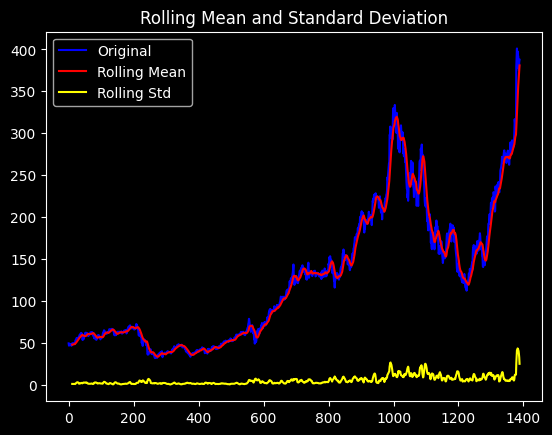

Results of dickey fuller test
Test Statistics                   0.624465
p-value                           0.988203
No. of lags used                 17.000000
Number of observations used    1371.000000
critical value (1%)              -3.435129
critical value (5%)              -2.863650
critical value (10%)             -2.567894
dtype: float64


In [34]:
test_stationarity(close_nvda)

## Train, test, valid

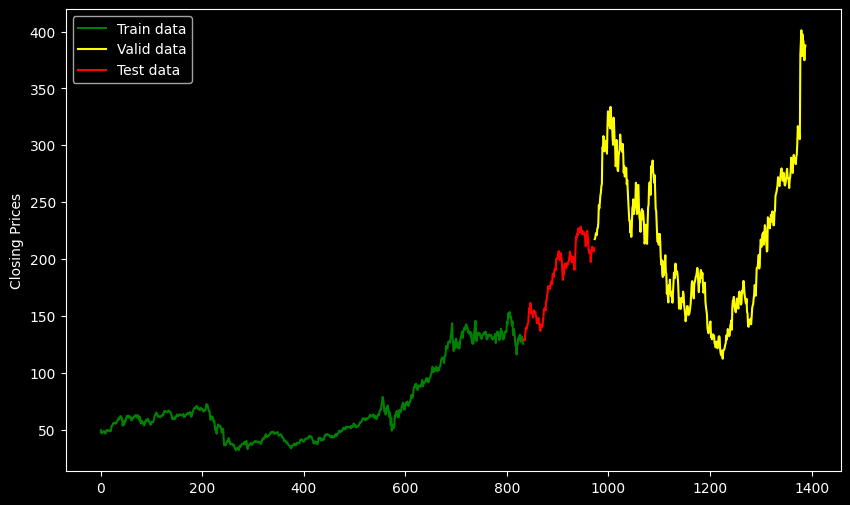

In [35]:
close_nvda = close_nvda.reset_index(drop=True)

train_data, test_data, valid_data = train_test_valid(close_nvda)

plt.figure(figsize=(10,6))
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(valid_data, 'yellow', label='Valid data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [36]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

## Build model

### Choose p, q, d

In [37]:
model_autoARIMA = auto_arima(y_train, start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

model_autoARIMA.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9635.031, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8523.506, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3763.002, Time=0.74 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.78 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3760.655, Time=0.82 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=7618.689, Time=1.27 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3766.804, Time=2.01 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=3761.969, Time=1.46 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=6859.316, Time=2.07 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=3762.853, Time=1.64 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3760.555, Time=0.36 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=6352.608, Time=0.98 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3762.664, Time=0.72 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  833
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -1875.278
Date:                Wed, 21 Jun 2023   AIC                           3760.555
Time:                        03:16:12   BIC                           3784.180
Sample:                             0   HQIC                          3769.613
                                - 833                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0724      0.208      0.348      0.728      -0.336       0.481
ar.L1          0.9991      0.002    505.017      0.000       0.995       1.003
ma.L1         -0.1484      0.020     -7.422      0.000      -0.188      -0.109
ma.L2          0.0768      0.022      3.548      0.000       0.034       0.119
sigma2         5.2440      0.145     36.138      0.000       4.960       5.528
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               805.48
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               4.51   Skew:                            -0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build model

In [38]:
model = ARIMA(y_train, order=(1,0,2)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  833
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1875.376
Date:                Wed, 21 Jun 2023   AIC                           3760.752
Time:                        03:16:12   BIC                           3784.377
Sample:                             0   HQIC                          3769.811
                                - 833                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         71.1272    123.343      0.577      0.564    -170.620     312.874
ar.L1          0.9993      0.002    556.207      0.000       0.996       1.003
ma.L1         -0.1485      0.020     -7.414      0.000      -0.188      -0.109
ma.L2          0.0767      0.022      3.546      0.000       0.034       0.119
sigma2         5.2443      0.146     36.019      0.000       4.959       5.530
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               810.65
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               4.52   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [39]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1))


x_val= np.array(valid_data.index).reshape(-1, 1)
y_val = np.array(valid_data['Close'])
y_pred_val =  model.predict(start=int(x_val[0]), end=int(len(x_val)+x_val[0]-1))

In [40]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  61.66918770087656
MAPE:  31.557497319208206
RMSE:  68.79421825455222

** Validate **
MAE:  104.61237807628669
MAPE:  43.533439789759775
RMSE:  122.17950047281921


## Forecast

In [41]:
last_index =  close_nvda.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1))

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[106.72292889 106.69631573 106.66972247 106.6431491  106.61659559
 106.59006194 106.56354812 106.53705412 106.51057994 106.48412554
 106.45769093 106.43127608 106.40488098 106.37850561 106.35214996
 106.32581402 106.29949777 106.27320119 106.24692428 106.22066701
 106.19442937 106.16821134 106.14201292 106.11583409 106.08967483
 106.06353513 106.03741497 106.01131434 105.98523322 105.9591716 ]


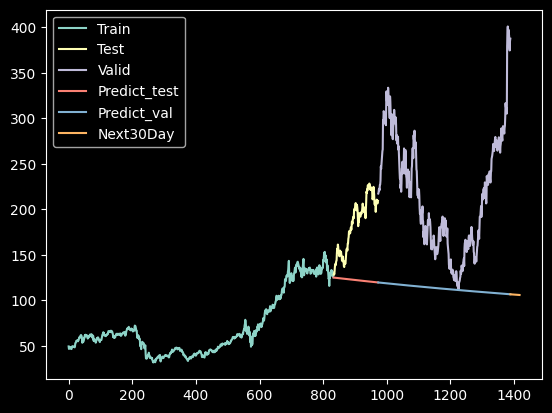

In [42]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(valid_data.index, valid_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(valid_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()

# TESLA

## Data

In [43]:
df_tsla = pd.read_csv("TSLA.csv")
df_tsla

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,20.362667,20.688000,20.336666,20.435333,20.435333,64393500
1,2017-12-04,20.433332,20.551332,20.040667,20.346666,20.346666,87526500
2,2017-12-05,20.133333,20.533333,20.066668,20.246668,20.246668,69697500
3,2017-12-06,20.006666,20.892668,20.000000,20.884001,20.884001,107929500
4,2017-12-07,20.799999,21.242001,20.736668,20.749332,20.749332,71709000
...,...,...,...,...,...,...,...
1384,2023-06-05,217.800003,221.289993,214.520004,217.610001,217.610001,151143100
1385,2023-06-06,216.139999,221.910004,212.529999,221.309998,221.309998,146911600
1386,2023-06-07,228.000000,230.830002,223.199997,224.570007,224.570007,185710800
1387,2023-06-08,224.220001,235.229996,223.009995,234.860001,234.860001,164489700


## Preprocessing

### Check null and na value

In [44]:
df_tsla.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [45]:
df_tsla.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check datatype of each column

In [46]:
print("Date column data type: ", type(df_tsla['Date'][0]))
print("Open column data type: ", type(df_tsla['Open'][0]))
print("Close column data type: ", type(df_tsla['Close'][0]))
print("High column data type: ", type(df_tsla['High'][0]))
print("Low column data type: ", type(df_tsla['Low'][0]))
print("Adj Close column data type: ", type(df_tsla['Adj Close'][0]))
print("Volume column data type: ", type(df_tsla['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [47]:
df_tsla['Date'] = pd.to_datetime(df_tsla.Date)

### Choose X

In [48]:
close_tsla = df_tsla[['Close']]

## EDA

### Get the duration of dataset

In [49]:
print("Starting date: ",df_tsla.iloc[0][0])
print("Ending date: ", df_tsla.iloc[-1][0])
print("Duration: ", df_tsla.iloc[-1][0]-df_tsla.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-06-09 00:00:00
Duration:  2016 days 00:00:00


### Visualize the per day closing price of the stock

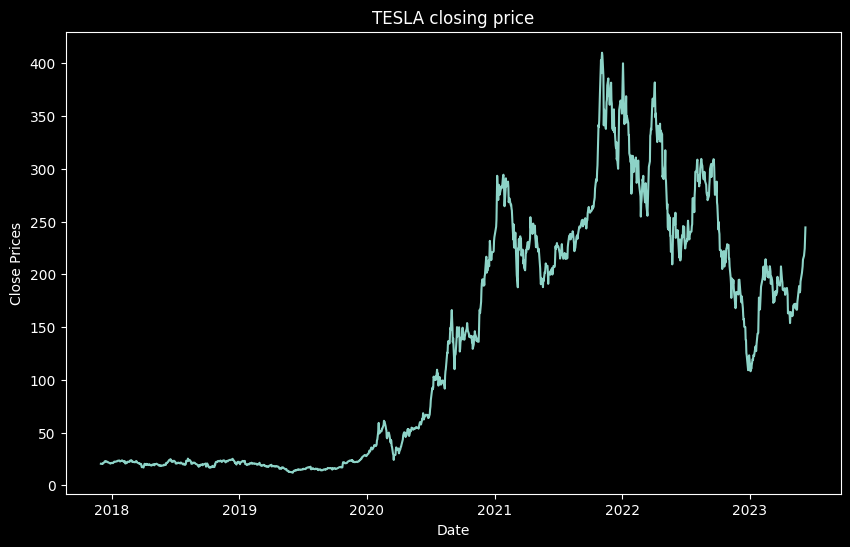

In [50]:
x_axis = np.array(df_tsla['Date'])

plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(x_axis,close_tsla)
plt.title('TESLA closing price')
plt.show()

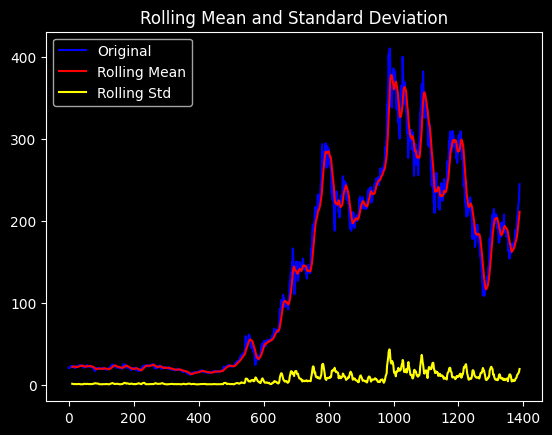

Results of dickey fuller test
Test Statistics                  -1.267376
p-value                           0.643963
No. of lags used                 24.000000
Number of observations used    1364.000000
critical value (1%)              -3.435153
critical value (5%)              -2.863661
critical value (10%)             -2.567899
dtype: float64


In [51]:
test_stationarity(close_tsla)

## Train, test, valid

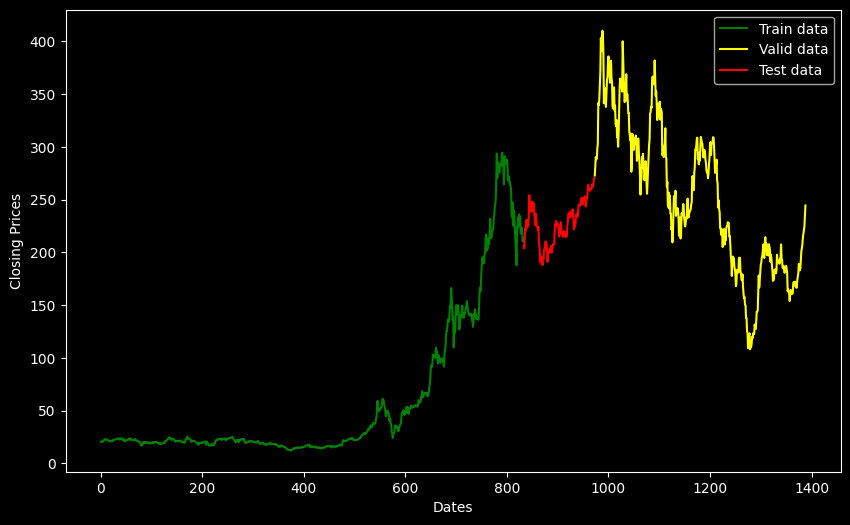

In [52]:
close_tsla = close_tsla.reset_index(drop=True)

train_data, test_data, valid_data = train_test_valid(close_tsla)

plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(valid_data, 'yellow', label='Valid data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [53]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

## Build model

### Choose p, q, d

In [54]:
model_autoARIMA = auto_arima(y_train, start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

model_autoARIMA.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9904.470, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8810.800, Time=0.29 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4749.778, Time=0.38 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4750.431, Time=0.88 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4751.708, Time=0.55 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=7876.798, Time=0.87 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.69 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4750.703, Time=0.38 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 4.425 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  833
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -2371.889
Date:                Wed, 21 Jun 2023   AIC                           4749.778
Time:                        03:16:18   BIC                           4763.953
Sample:                             0   HQIC                          4755.213
                                - 833                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9996      0.001   1929.705      0.000       0.999       1.001
ma.L1         -0.0704      0.015     -4.847      0.000      -0.099      -0.042
sigma2        17.2616      0.290     59.493      0.000      16.693      17.830
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              8974.25
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):              93.60   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build model

In [55]:
model = ARIMA(y_train, order=(1,0,1)).fit()
model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  833
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2371.489
Date:                Wed, 21 Jun 2023   AIC                           4750.977
Time:                        03:16:19   BIC                           4769.878
Sample:                             0   HQIC                          4758.224
                                - 833                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.2767    323.713      0.183      0.855    -575.188     693.742
ar.L1          0.9992      0.002    527.623      0.000       0.996       1.003
ma.L1         -0.0702      0.015     -4.779      0.000      -0.099      -0.041
sigma2        17.2598      0.291     59.370      0.000      16.690      17.830
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8971.45
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):              92.15   Skew:                             0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [56]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1))


x_val= np.array(valid_data.index).reshape(-1, 1)
y_val = np.array(valid_data['Close'])
y_pred_val =  model.predict(start=int(x_val[0]), end=int(len(x_val)+x_val[0]-1))

In [57]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  26.414770817560186
MAPE:  11.018268990073203
RMSE:  32.484891318080855

** Validate **
MAE:  79.85623819258609
MAPE:  28.51684108191952
RMSE:  96.95451347539054


## Forecast

In [58]:
last_index =  close_tsla.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1))

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[159.30810657 159.23065627 159.15326594 159.07593554 158.998665
 158.92145429 158.84430337 158.76721218 158.69018067 158.61320881
 158.53629655 158.45944383 158.38265062 158.30591687 158.22924253
 158.15262756 158.0760719  157.99957552 157.92313837 157.8467604
 157.77044156 157.69418182 157.61798112 157.54183942 157.46575668
 157.38973284 157.31376786 157.2378617  157.16201432 157.08622565]


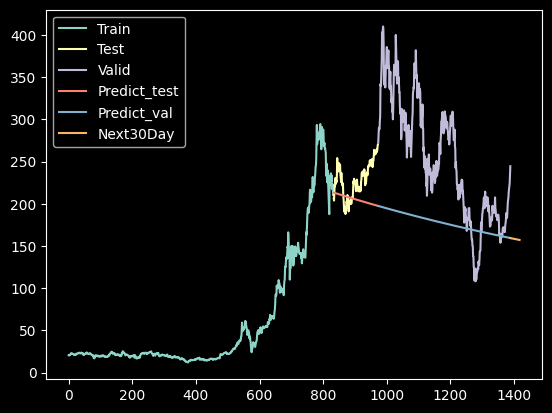

In [59]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(valid_data.index, valid_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(valid_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()